<a href="https://colab.research.google.com/github/kayserim/prj_id/blob/main/train_and_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [172]:
from google.colab import drive
drive.mount("/content/drive")
%cd '/content/drive/MyDrive/cse6250_proj'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/cse6250_proj


In [173]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, RocCurveDisplay, auc, PrecisionRecallDisplay, recall_score, precision_score
import seaborn as sns

from utils import train, evaluate, load_dataset, plot_learning_curves
from mymodels import MyLR, MyLSTM, MyLSTMCNN

# Set a correct path to the seizure data file you downloaded
PATH_TRAIN_FILE = "./data/all/XY_train_LITE.csv"
PATH_VALID_FILE = "./data/all/XY_validation_LITE.csv"
PATH_TEST_FILE = "./data/all/XY_test_LITE.csv"

# TODO need to match hyperparameters to paper
MODEL_TYPE = 'LSTMCNN' #LR, LSTM, LSTMCNN 

ALL_SETTINGS = {'LR':     {'LR':0.002,  'NUM_EPOCHS':16 ,'BATCH_SIZE':48, 'LSTM_HIDDEN_SIZE':1 ,  'LSTM_DROPOUT':1}, #hidden size and dropout are don't care for logistic regression
                'LSTM':   {'LR':0.0004, 'NUM_EPOCHS':96 ,'BATCH_SIZE':64, 'LSTM_HIDDEN_SIZE':24 , 'LSTM_DROPOUT':0.04},
                'LSTMCNN':{'LR':0.0008, 'NUM_EPOCHS':96 ,'BATCH_SIZE':64, 'LSTM_HIDDEN_SIZE':24 , 'LSTM_DROPOUT':0.06}
                }

NUM_EPOCHS = ALL_SETTINGS[MODEL_TYPE]['NUM_EPOCHS']
BATCH_SIZE = ALL_SETTINGS[MODEL_TYPE]['BATCH_SIZE']

class model_config:
  LSTM_HIDDEN_SIZE = ALL_SETTINGS[MODEL_TYPE]['LSTM_HIDDEN_SIZE']
  LSTM_NUM_LAYERS = 3 # fixed to 3 as in paper
  LSTM_DROPOUT = ALL_SETTINGS[MODEL_TYPE]['LSTM_DROPOUT']

USE_CUDA = True  # Set 'True' if you want to use GPU
NUM_WORKERS = 0  # Number of threads used by DataLoader. You can adjust this according to your machine spec.

HOURS_LIMIT = 48




In [174]:
def plot_auc(y_t: list, y_p: list, name: str):
  '''This function displays AUC and a ROC curve.

  Params:
    y_t: actual y data
    y_p: probability of class 1 vector
    name: name of estimator
  '''
  fpr, tpr, thresholds = roc_curve(y_t, y_p)
  roc_auc = auc(fpr, tpr)
  display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
  display.plot()
  plt.show()

In [175]:
def plot_precision_recall(y_t: list, y_p: list, name: str):
  '''This function displays AUC and a ROC curve.

  Params:
    y_t: actual y data
    y_p: probability of class 1 vector
    name: name of estimator
  '''
  display = PrecisionRecallDisplay.from_predictions(y_t, y_p, name = name)
  _ = display.ax_.set_title("{} Precision-Recall curve".format(name))

In [ ]:
# mostly taken from trainseizure.py
device = torch.device("cuda" if USE_CUDA and torch.cuda.is_available() else "cpu")
if device.type == "cuda":
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

num_features, train_dataset = load_dataset(PATH_TRAIN_FILE, MODEL_TYPE, HOURS_LIMIT)
_, valid_dataset = load_dataset(PATH_VALID_FILE, MODEL_TYPE, HOURS_LIMIT)
_, test_dataset = load_dataset(PATH_TEST_FILE, MODEL_TYPE, HOURS_LIMIT)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

if MODEL_TYPE == 'LR':
	model = MyLR(num_features)
elif MODEL_TYPE == 'LSTM':
	model = MyLSTM(num_features, config=model_config)
elif MODEL_TYPE == 'LSTMCNN':
	model = MyLSTMCNN(num_features, config=model_config)
else:
	raise AssertionError("Wrong Model Type!")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

best_val_acc = 0.0
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

best_model = None
for epoch in range(NUM_EPOCHS):
	train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer, epoch)
	valid_loss, valid_accuracy, valid_results = evaluate(model, device, valid_loader, criterion)

	train_losses.append(train_loss)
	valid_losses.append(valid_loss)

	train_accuracies.append(train_accuracy)
	valid_accuracies.append(valid_accuracy)

	is_best = valid_accuracy > best_val_acc  # let's keep the model that has the best accuracy, but you can also use another metric.
	if is_best:
		best_val_acc = valid_accuracy
		best_model= model


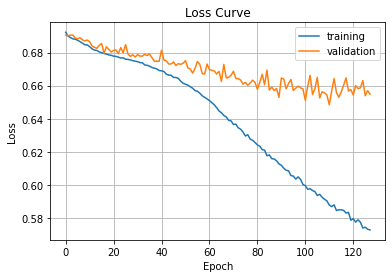

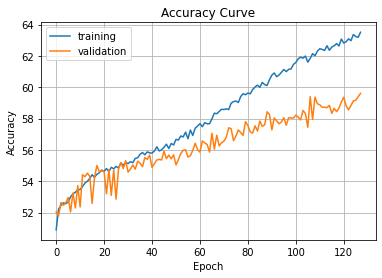

Test: [0/125]	Time 0.002 (0.002)	Loss 0.7059 (0.7059)	Accuracy 59.375 (59.375)
Test: [10/125]	Time 0.002 (0.002)	Loss 0.6264 (0.6537)	Accuracy 64.062 (64.062)
Test: [20/125]	Time 0.002 (0.002)	Loss 0.5534 (0.6692)	Accuracy 64.062 (61.012)
Test: [30/125]	Time 0.002 (0.002)	Loss 0.6513 (0.6796)	Accuracy 54.688 (58.921)
Test: [40/125]	Time 0.002 (0.002)	Loss 0.6719 (0.6826)	Accuracy 56.250 (59.108)
Test: [50/125]	Time 0.001 (0.002)	Loss 0.6049 (0.6780)	Accuracy 56.250 (59.252)
Test: [60/125]	Time 0.002 (0.002)	Loss 0.6410 (0.6678)	Accuracy 65.625 (59.401)
Test: [70/125]	Time 0.002 (0.002)	Loss 0.6912 (0.6626)	Accuracy 53.125 (59.419)
Test: [80/125]	Time 0.001 (0.002)	Loss 0.7712 (0.6598)	Accuracy 48.438 (59.703)
Test: [90/125]	Time 0.001 (0.002)	Loss 0.6503 (0.6580)	Accuracy 57.812 (59.804)
Test: [100/125]	Time 0.002 (0.002)	Loss 0.5643 (0.6565)	Accuracy 65.625 (59.870)
Test: [110/125]	Time 0.002 (0.002)	Loss 0.7403 (0.6552)	Accuracy 62.500 (60.008)
Test: [120/125]	Time 0.002 (0.002)	Loss

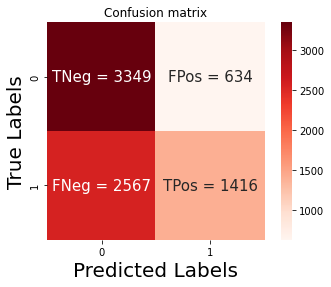

In [177]:
plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies)
test_loss, test_accuracy, test_results = evaluate(best_model, device, test_loader, criterion)
y_true, y_pred, y_probs = zip(*test_results)   
y_prob = [x[1] for x in y_probs]
cm=confusion_matrix(y_true, y_pred)
sns.heatmap(cm, square=True, cmap='Reds', xticklabels=['0', '1'], yticklabels=['0', '1'], annot=[['TNeg = {}'.format(cm[0][0]), 'FPos = {}'.format(cm[0][1])],
                                                                                                ['FNeg = {}'.format(cm[1][0]), 'TPos = {}'.format(cm[1][1])]], fmt="", annot_kws={"size": 15})
plt.ylabel('True Labels', fontsize=20);
plt.xlabel('Predicted Labels', fontsize=20);
plt.title("Confusion matrix")
plt.show()



In [178]:
print(f'test accuracy is: {test_accuracy}')
print(f'test recall is: {recall_score(y_true, y_pred)}')
print(f'test precision is: {precision_score(y_true, y_pred)}')
print(f'test roc_auc is: {roc_auc_score(y_true, y_prob)}')

test accuracy is: 59.816721069312955
test recall is: 0.3555109214160181
test precision is: 0.6907317073170731
test roc_auc is: 0.6653226942600453


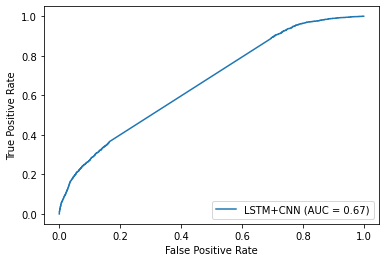

In [179]:
plot_auc(y_true, y_prob, 'LSTM+CNN')

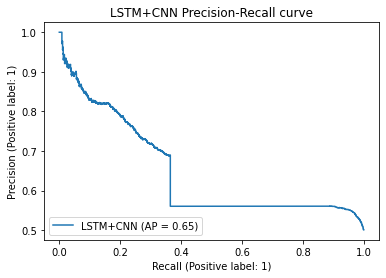

In [180]:
plot_precision_recall(y_true, y_prob, 'LSTM+CNN')

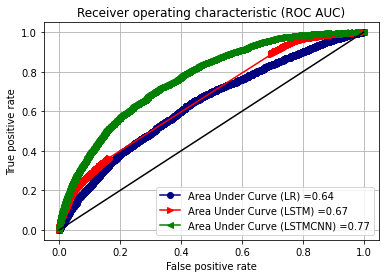

In [181]:
##UNCOMMENT FOR ROC_AUC FOR ALL - writes previous data to directory though
#import json
#import os
#
#def plot_roc_auc(data, info):
#  markers=['o','>','<','+','*','s','d','.']
#  colors=['navy','red','green','magenta']
#  for i,data_dict in enumerate(data):
#    fpr, tpr, threshold = roc_curve(data_dict['labels'],   data_dict['predictions'])
#    model_name = data_dict['model']
#    plt.plot(fpr, tpr, label = f'Area Under Curve ({model_name}) ={auc(fpr, tpr):.2f}', marker=markers[i%len(markers)], color=colors[i%len(colors)])
#  plt.plot([0, 1], [0, 1],'black')
#  plt.title(f'Receiver operating characteristic ({info})')
#  plt.ylabel('True positive rate')
#  plt.xlabel('False positive rate')
#  plt.legend(loc = 'best')
#  plt.grid()
#  plt.show()
#
#roc_auc_data=[{'model':MODEL_TYPE, 'labels':y_true, 'predictions':y_prob}] 
#with open('ROCAUC_'+MODEL_TYPE+'.txt', 'w') as f:
#  f.write(json.dumps(roc_auc_data))
#
#all_roc_auc_data=[]
#for filename in os.listdir("."):
#  if filename.startswith("ROCAUC_"):
#    with open(filename) as f:
#      data = f.read()
#      all_roc_auc_data.append(json.loads(data)[0])
#  
#plot_roc_auc(all_roc_auc_data, 'ROC AUC' )

In [182]:
# was hoping that this code will generate a nice visualization for the model but it is pretty complicated (see below) hence disabled the execution of the cell
#!pip install wandb -Uq
#
#import torch.onnx
#import wandb
#wandb.login()
#with wandb.init(project="test-demo", settings=wandb.Settings(symlink=False)) as run:
#  dummy_input, _ = next(iter(valid_loader))
#  torch.onnx.export(best_model, dummy_input.to(device), "model.onnx")
#  model_artifact = wandb.Artifact("test", type="model", description="test")
#  model_artifact.add_file("model.onnx")
#  run.log_artifact(model_artifact)

was hoping that above code will generate a nice visualization for the model but it is pretty complicated (see below) hence disabled the execution of the cell


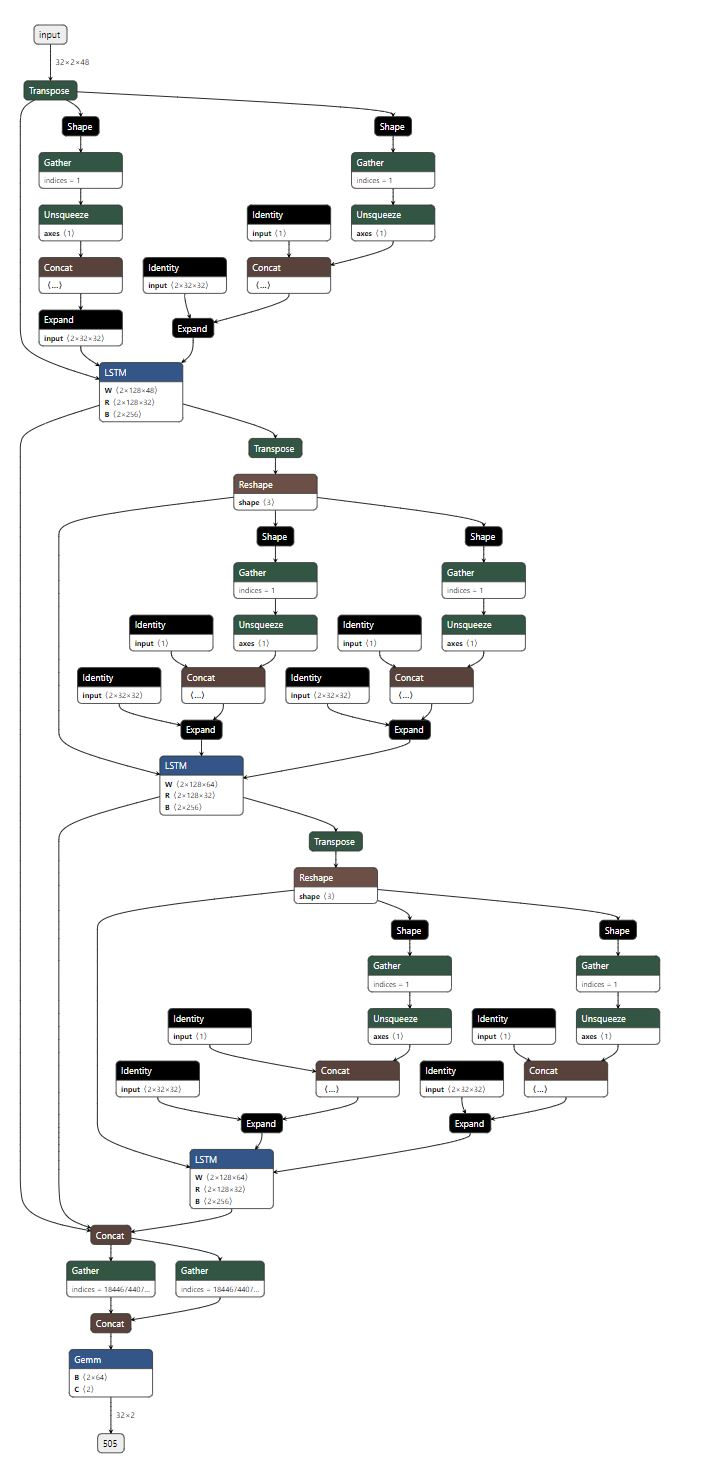